In [20]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
from scipy.linalg import hankel

params = {}
params['embedding_dimension'] = 4
params['partial_measurement'] =7
params['latent_dim'] = 10

In [21]:
with open('Results/final_output.pkl', 'rb') as f:
    results = pickle.load(f)

X_ori = results['x'].cpu().detach().numpy()
dx_ori = results['dx'].cpu().detach().numpy()
z = results['z'].cpu().detach().numpy()
sindy_coeff = results['sindy_coefficients'].cpu().detach().numpy()
Theta = results['Theta'].cpu().detach().numpy()

measured_index = [i*params['embedding_dimension'] for i in range(params['partial_measurement'])]
X_ori = X_ori[:, measured_index]
dx_ori = dx_ori[:, measured_index]

In [22]:
train_loss = np.load("Results/train_loss.npy")
val_loss = np.load("Results/val_loss.npy")
refine_loss = np.load("Results/refine_loss.npy")
refine_val_loss = np.load("Results/refine_val_loss.npy")

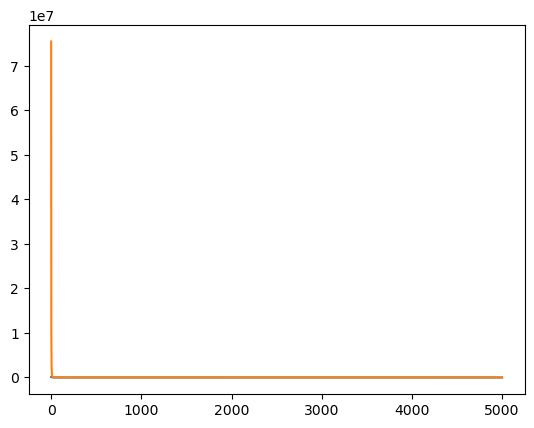

In [23]:
plt.plot(train_loss)
plt.plot(val_loss)

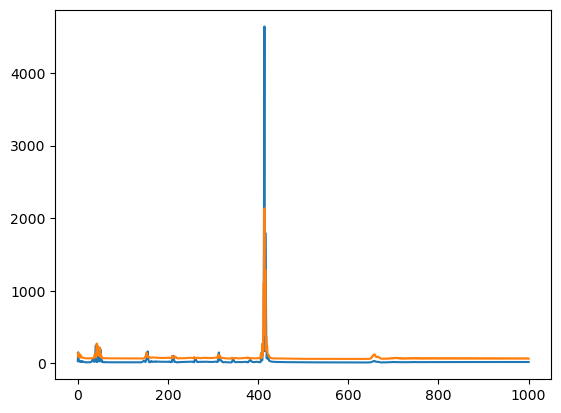

In [24]:
plt.plot(refine_loss)
plt.plot(refine_val_loss)

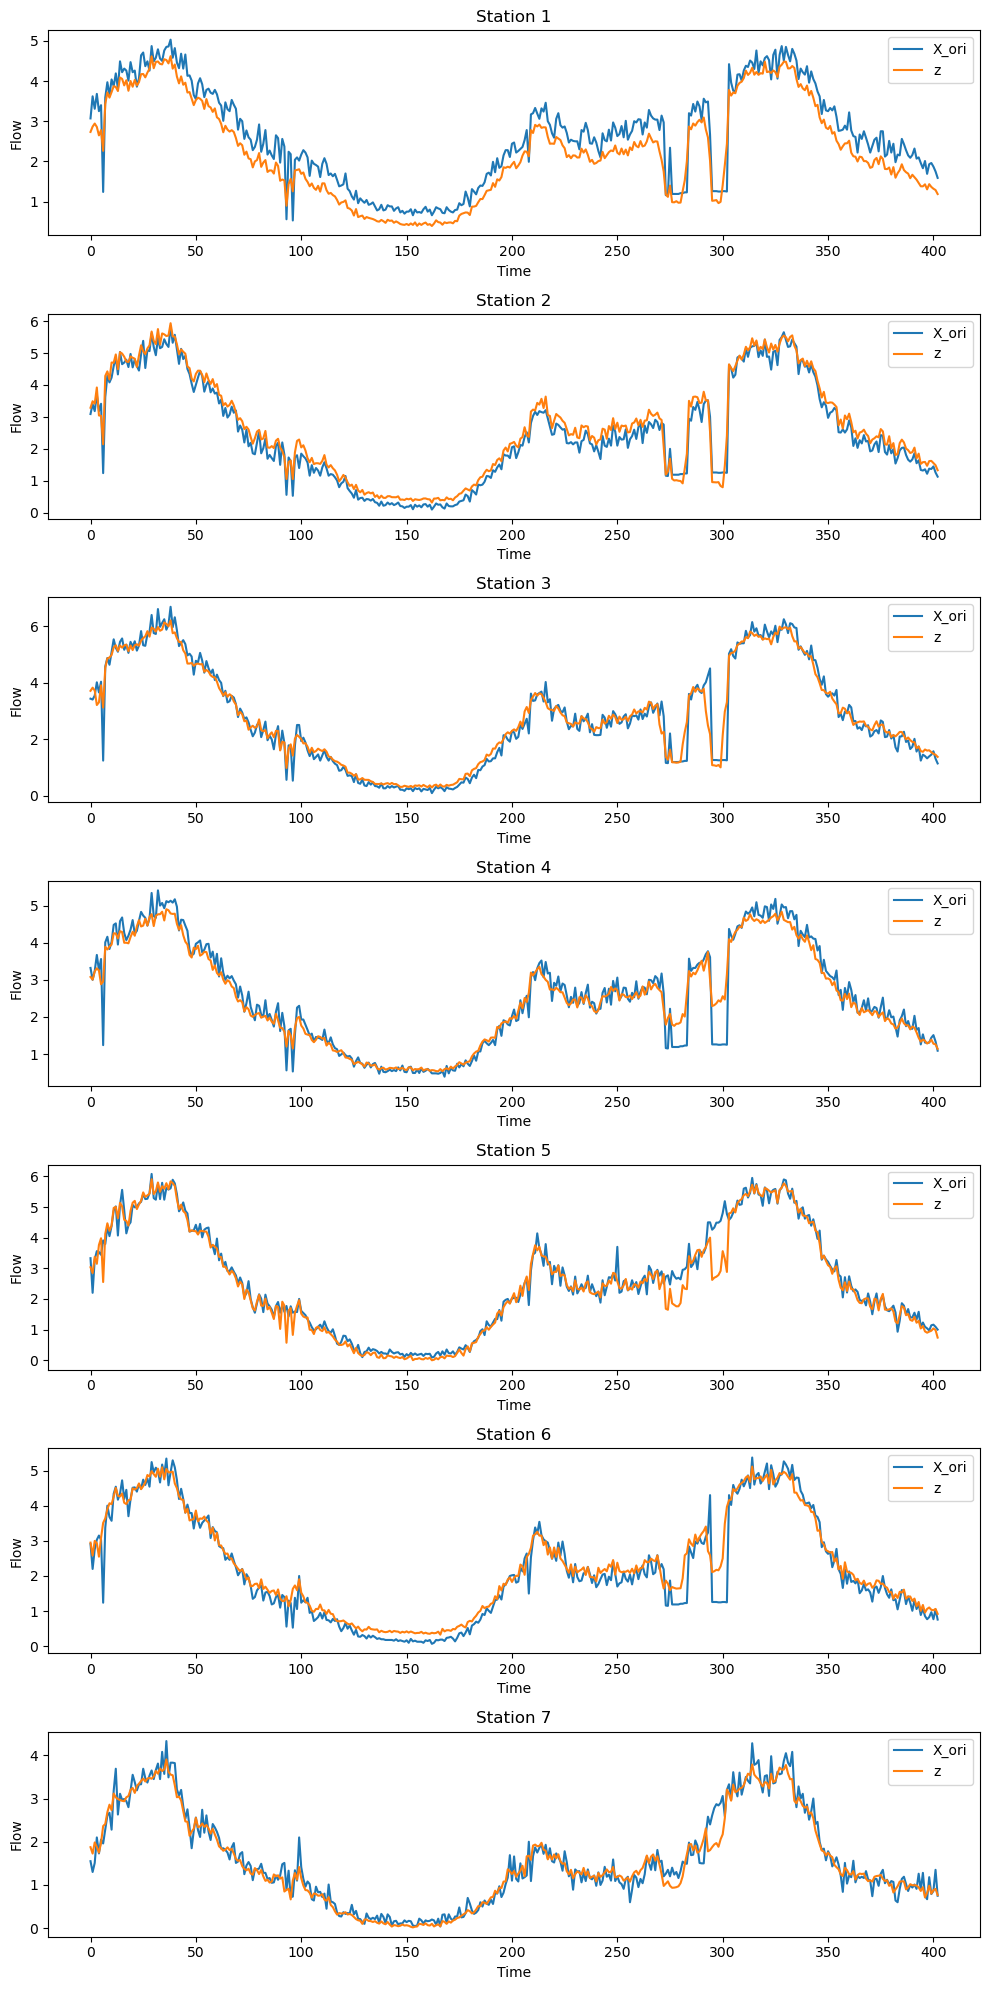

In [25]:
# Create a figure with 5 subplots (one for each column)
fig, axs = plt.subplots(nrows=X_ori.shape[1], ncols=1, figsize=(10, 20))

# Plot each column in a separate subplot
for i in range(X_ori.shape[1]):
    axs[i].plot(X_ori[:, i], label = 'X_ori')
    axs[i].plot(z[:,i], label = 'z')
    axs[i].legend()

# Add titles and axis labels to the subplots
for i, ax in enumerate(axs):
    ax.set_title(f'Station {i+1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Flow')

# Show the figure
plt.tight_layout()
plt.show()

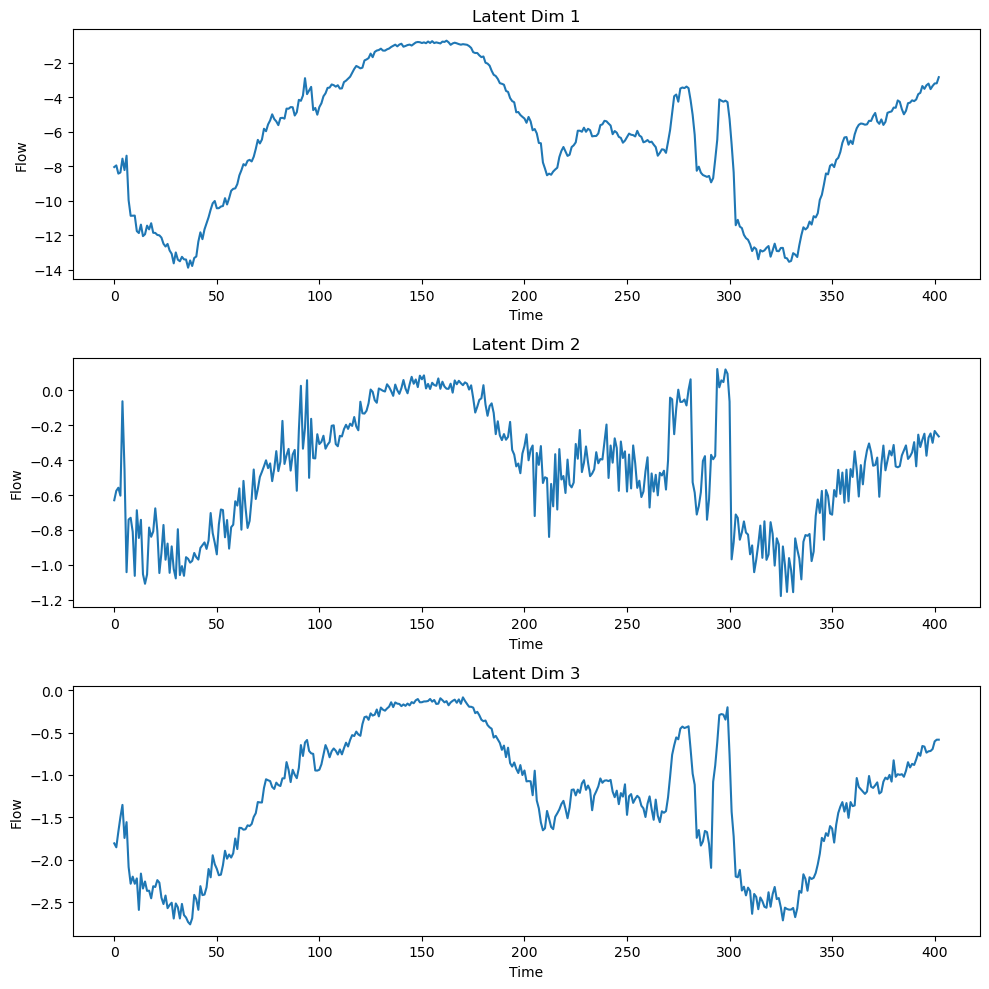

In [26]:
fig, axs = plt.subplots(nrows=params['latent_dim'] - params['partial_measurement'], ncols=1, figsize=(10, 10))

# Plot each column in a separate subplot
for i in range(params['partial_measurement'],z.shape[1]):
    #axs[i].plot(X_ori[:, i])
    axs[i-params['partial_measurement']].plot(z[:,i])

# Add titles and axis labels to the subplots
for i, ax in enumerate(axs):
    ax.set_title(f'Latent Dim {i+1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Flow')

# Show the figure
plt.tight_layout()
plt.show()

In [27]:
dz_predict = results['dz_predict'].cpu().detach().numpy()
dz = results['dz'].cpu().detach().numpy()

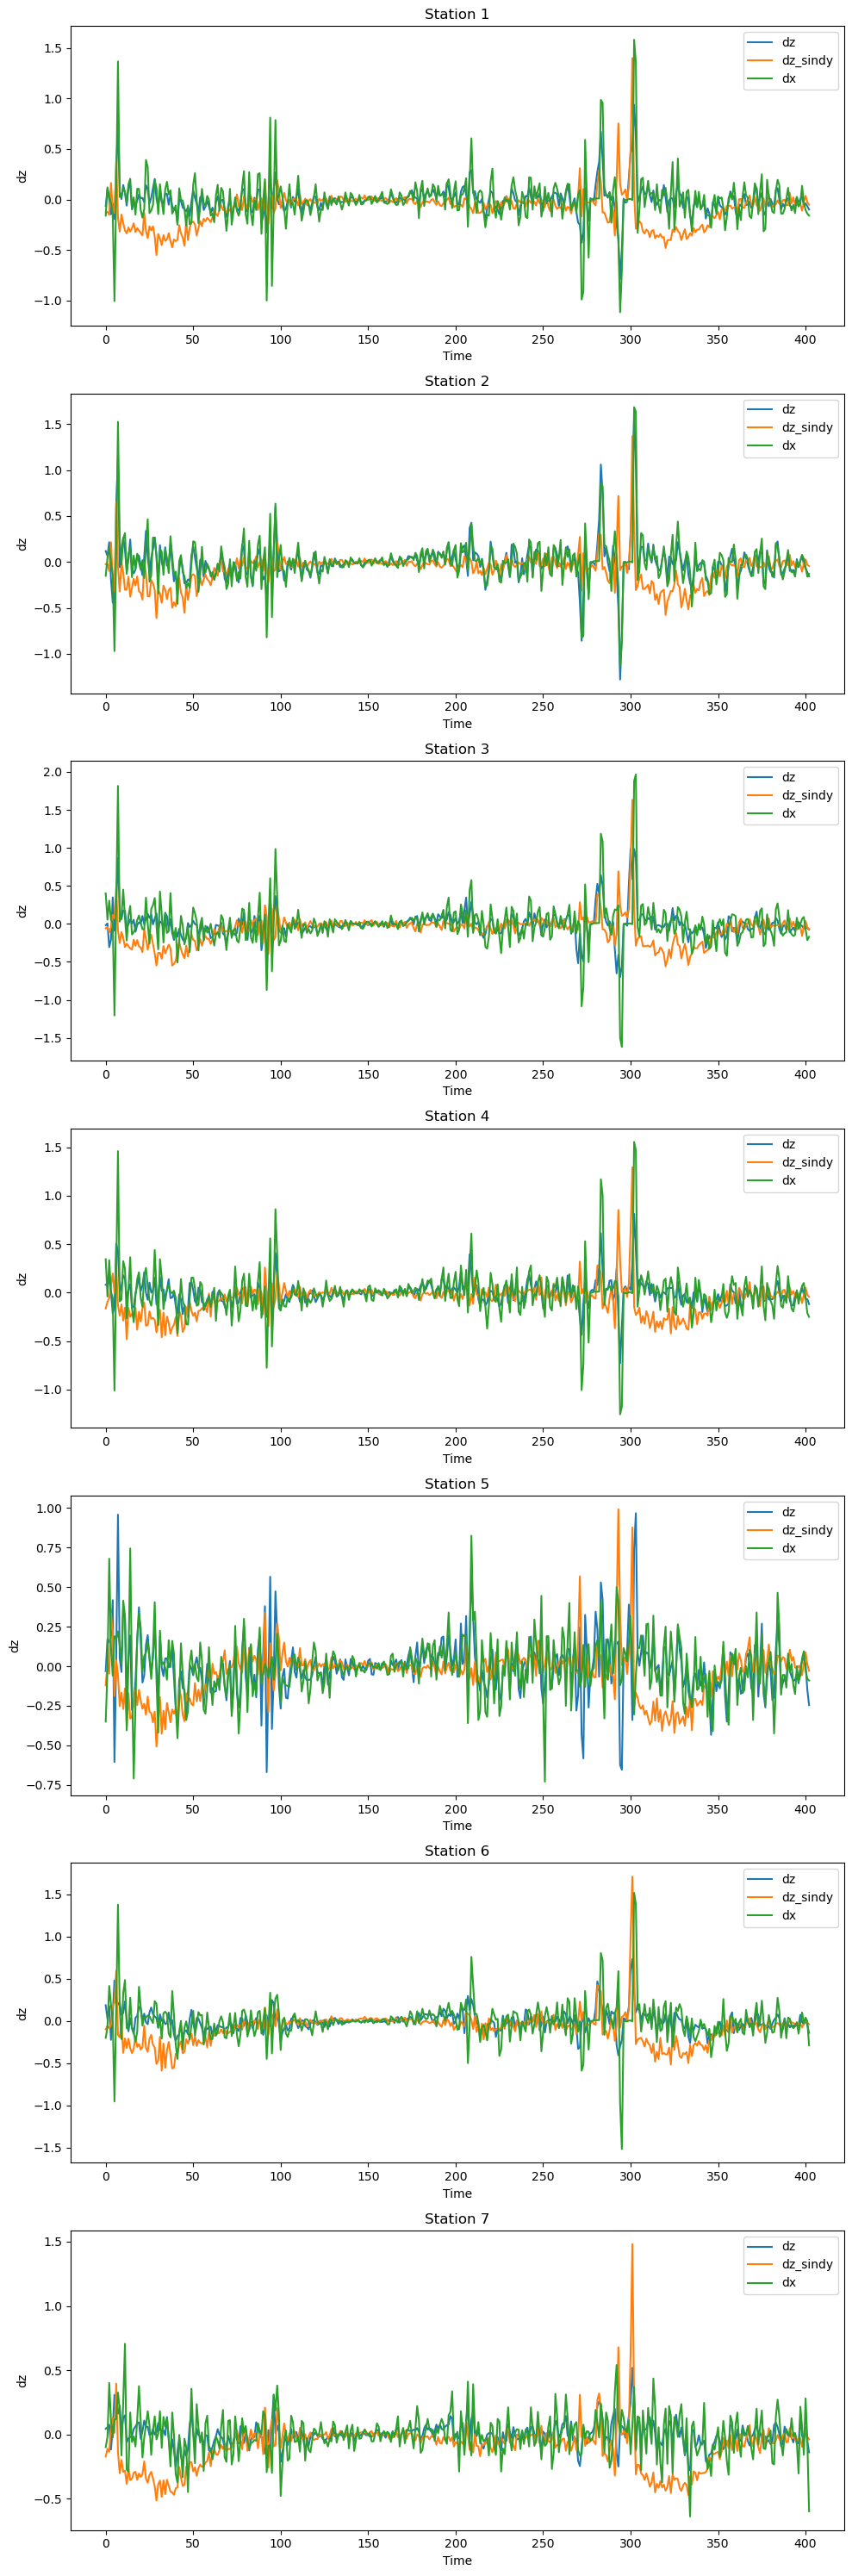

In [28]:
fig, axs = plt.subplots(nrows=dx_ori.shape[1], ncols=1, figsize=(10, 30))

# Plot each column in a separate subplot
for i in range(dx_ori.shape[1]):
    axs[i].plot(dz[:, i], label = 'dz')
    axs[i].plot(dz_predict[:,i], label = 'dz_sindy')
    axs[i].plot(dx_ori[:,i], label = 'dx')
    axs[i].legend()

# Add titles and axis labels to the subplots
for i, ax in enumerate(axs):
    ax.set_title(f'Station {i+1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('dz')

# Show the figure
plt.tight_layout()
plt.show()

In [56]:
#Simulate data with discovered governing equations
total_sim_timestep = 402
total_pred_step = 3
s = (total_sim_timestep, 10)
sim_result = np.zeros(s)

In [57]:
from sindy_utils import sindy_library

In [58]:
for t in range(0,total_sim_timestep,total_pred_step):
    z_init = z[t,:].reshape(1,-1)
    for s in range(total_pred_step):
        Theta_curr = sindy_library(z_init,2,False)
        dz_curr = np.matmul(Theta_curr,sindy_coeff)
        z_new = z_init + dz_curr
        sim_result[t+s,:] = z_init
        z_init = np.array(z_new)

In [59]:
sim_result

array([[ 2.73330569e+00,  3.28658867e+00,  3.70736408e+00, ...,
        -8.03866386e+00, -6.29995644e-01, -1.80619919e+00],
       [ 2.60641132e+00,  3.26361275e+00,  3.64883256e+00, ...,
        -8.38845355e+00, -6.76703430e-01, -2.11181849e+00],
       [ 3.14228020e+00,  3.76282271e+00,  4.18005362e+00, ...,
        -7.80459891e+00, -3.14030877e-03, -1.80769709e+00],
       ...,
       [ 1.36521614e+00,  1.62348700e+00,  1.53723383e+00, ...,
        -3.33994150e+00, -3.01326811e-01, -6.93341494e-01],
       [ 1.34443429e+00,  1.61128393e+00,  1.50429090e+00, ...,
        -3.37539180e+00, -2.63732434e-01, -7.21780535e-01],
       [ 1.26589378e+00,  1.52542647e+00,  1.41152457e+00, ...,
        -3.43864919e+00, -2.71458992e-01, -8.11544665e-01]])

In [60]:
z

array([[ 2.7333057 ,  3.2865887 ,  3.707364  , ..., -8.038664  ,
        -0.62999564, -1.8061992 ],
       [ 2.8659034 ,  3.489985  ,  3.818987  , ..., -7.944427  ,
        -0.5758708 , -1.8527876 ],
       [ 2.9420335 ,  3.417056  ,  3.7179878 , ..., -8.420896  ,
        -0.558279  , -1.6680793 ],
       ...,
       [ 1.3199939 ,  1.5561682 ,  1.4823769 , ..., -3.1964571 ,
        -0.23358448, -0.60392666],
       [ 1.2876935 ,  1.4881109 ,  1.4464507 , ..., -3.1887348 ,
        -0.25010836, -0.58357775],
       [ 1.1880404 ,  1.3311982 ,  1.3718694 , ..., -2.8330636 ,
        -0.26464754, -0.5836235 ]], dtype=float32)

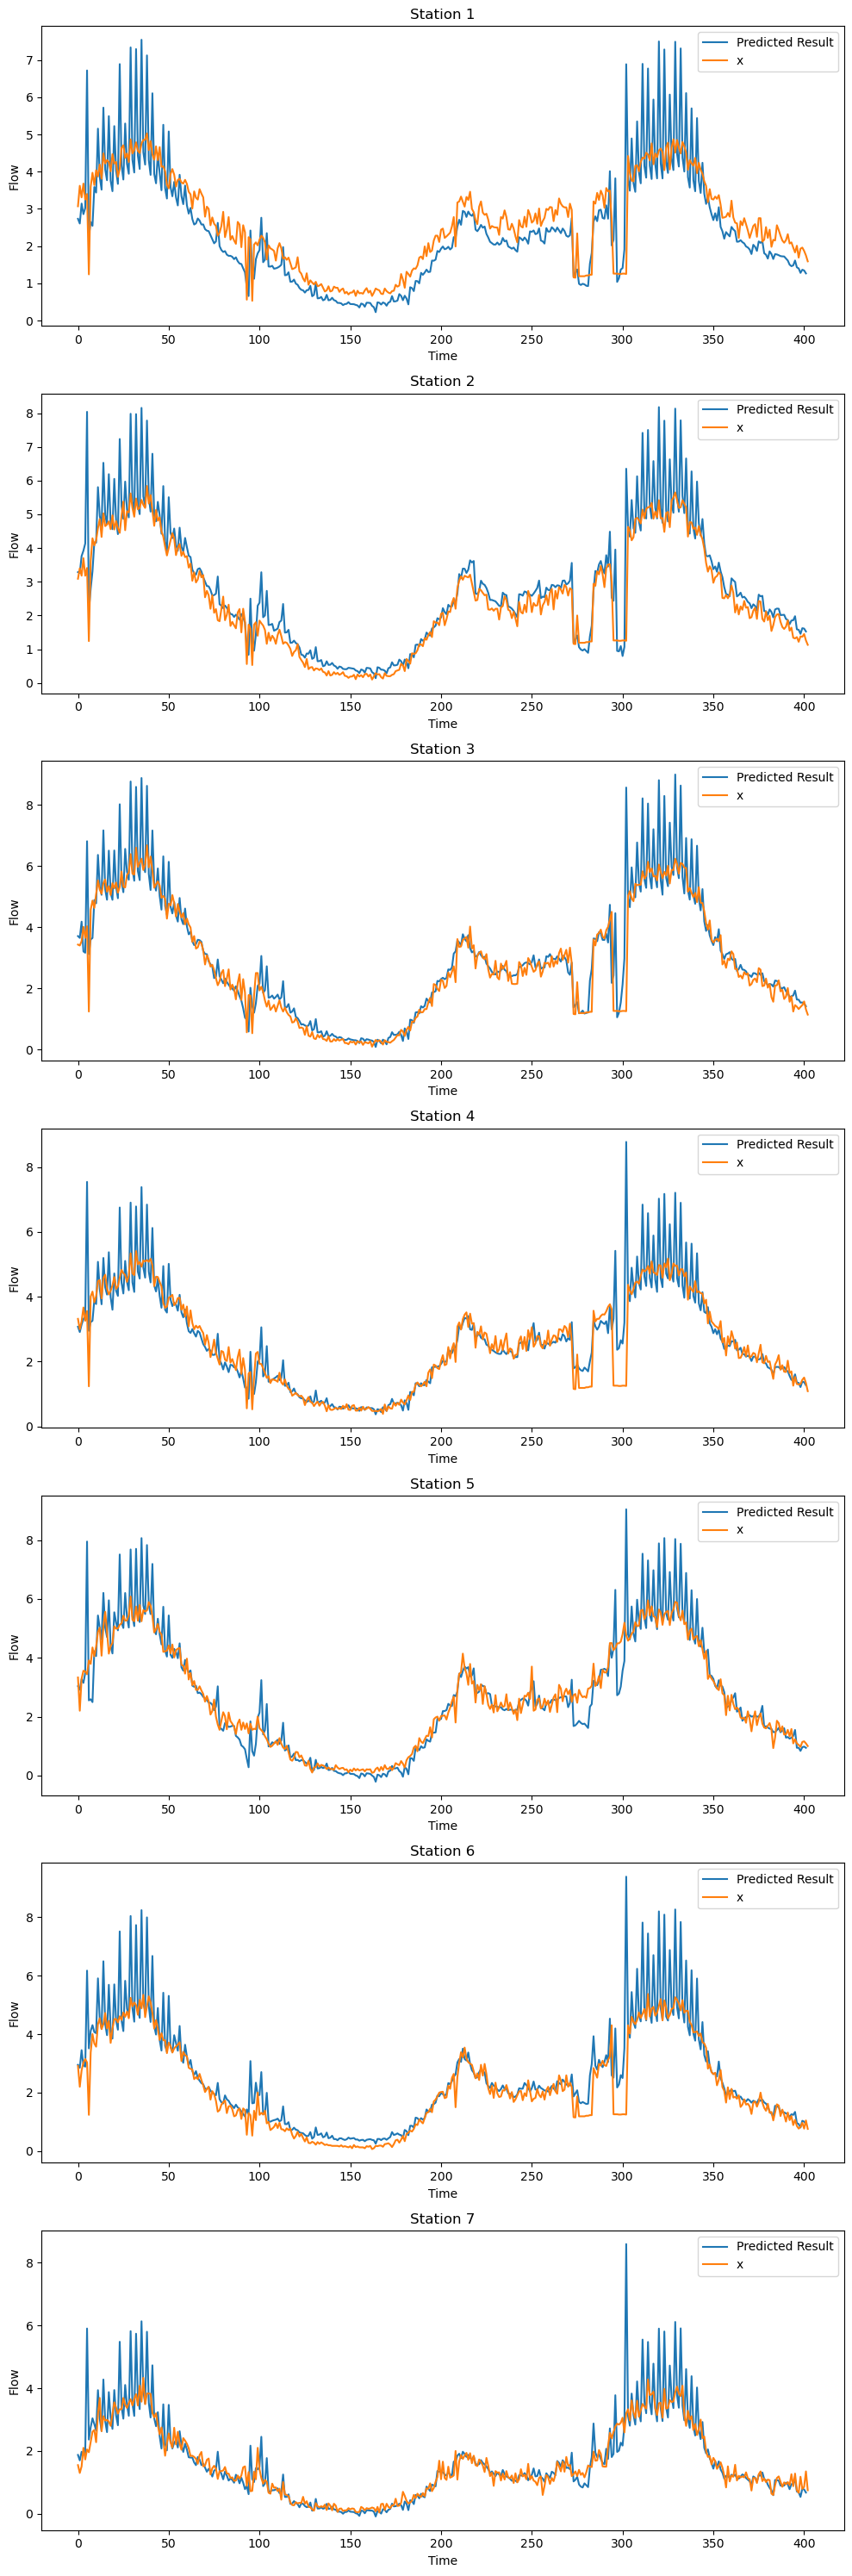

In [61]:
fig, axs = plt.subplots(nrows=X_ori.shape[1], ncols=1, figsize=(10, 30))

# Plot each column in a separate subplot
for i in range(X_ori.shape[1]):
    axs[i].plot(sim_result[:, i], label = 'Predicted Result')
    axs[i].plot(X_ori[:,i], label = 'x')
    axs[i].legend()

# Add titles and axis labels to the subplots
for i, ax in enumerate(axs):
    ax.set_title(f'Station {i+1}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Flow')

# Show the figure
plt.tight_layout()
plt.show()

# Phase Plane